3η Εργασία

Ονοματεπώνυμο : Κωνσταντίνος Κίτσος

Α.Μ: 1115201900082

---



# Ερώτημα 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os

data_path=('/content/drive/MyDrive/Anagnorisi Protypon - Machine Learning/Ergasia3/data/music_genre_data_di/')

train_X = np.load(data_path + 'train/mfccs/X.npy')
test_X = np.load(data_path + 'test/mfccs/X.npy')
val_X = np.load(data_path + 'val/mfccs/X.npy')

train_labels_STR=np.load(data_path + 'train/mfccs/labels.npy')
test_labels_STR=np.load(data_path + 'test/mfccs/labels.npy')
val_labels_STR=np.load(data_path + 'val/mfccs/labels.npy')



In [ ]:
mapping = {'blues':0,'classical':1,'hiphop':2,'rock_metal_hardrock':3}

def toInt(name):
  return mapping[name]

train_labels= list( map(toInt,train_labels_STR))
val_labels= list( map(toInt,val_labels_STR))
test_labels= list( map(toInt,test_labels_STR))


In [ ]:
# we create a Dataset class as instructed from https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

class CustomDataset: #(Dataset):
    def __init__(self, X,labels, transform=None, target_transform=None):
        self.X = X
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data=self.X[idx,:]  # data = MFCCs or Melgrams
        label = self.labels[idx]
        if self.transform !=None :
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)

        return data , label


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
#from torchvision.transforms import ToTensor

print(torch.__version__)



train_data=CustomDataset(train_X,train_labels,transform=torch.Tensor)
val_data=CustomDataset(val_X,val_labels,transform=torch.Tensor)
test_data=CustomDataset(test_X,test_labels,transform=torch.Tensor)

2.0.1+cu118


In [ ]:


"""  Probably also works
train_data= list(zip(torch.Tensor(train_X),train_labels))
val_data= list(zip(  torch.Tensor(val_X) , val_labels) ))
test_data= list(zip(  torch.Tensor(test_X) ,  test_labels ))
"""


'  Probably also works\ntrain_data= list(zip(torch.Tensor(train_X),train_labels))\nval_data= list(zip(  torch.Tensor(val_X) , val_labels) ))\ntest_data= list(zip(  torch.Tensor(test_X) ,  test_labels ))\n'

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__() ## call the constructor of super
        #!!!  self.flatten = nn.Flatten()   # NOT NEEDED

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(26, 128),  ##torch.nn.Linear(in_features, out_features)
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 4),
        )

    ## Every nn.Module subclass implements the operations on input data in the forward method.
    def forward(self, x):
        #!!!  x = self.flatten(x)   # NOT NEEDED
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork()

# print the model structure
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=26, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)


#Βήμα 3:

In [ ]:
device='cpu'

In [ ]:
# taken from seminar 7


def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):

        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [ ]:
def train(num_epochs , optimizer , dataloader, loss_fn, model):  # model= neural model
  for t in range(num_epochs):
    train_loop(dataloader, model, loss_fn, optimizer)


#Βήμα 4:

In [ ]:
from IPython.core.interactiveshell import prepended_to_syspath

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score

#pred_probs = nn.Softmax(dim=1)(logits)

In [ ]:
#MODIFIED FROM SEMINAR 7

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    y_total=torch.empty(0, dtype=torch.float32).to(device)
    y_pred_total=torch.empty(0, dtype=torch.float32).to(device)
    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():
        for X, y in dataloader:

            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)



            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            y_total=torch.cat((y_total,y))
            y_pred_total=torch.cat((y_pred_total,pred.argmax(1)))

    accuracy= 100*(y_pred_total == y_total).type(torch.float).sum().item()/size

    y_total = y_total.cpu().numpy() # numpy conversion needs cpu device
    y_pred_total = y_pred_total.cpu().numpy()

    test_loss /= size
    f1= 100*f1_score(y_total,y_pred_total,average='macro')
    CM=confusion_matrix(y_total,y_pred_total,labels=[0,1,2,3])

    return test_loss,f1,accuracy,CM

#Βήμα 5



In [ ]:
import time

In [ ]:
#INITIALIZTIONS
device="cpu"

model = NeuralNetwork()

X = torch.rand(1,26)

logits = model(X)
#print ("logits=",logits)

pred_probs = nn.Softmax(dim=1)(logits)



learning_rate= 0.002

optimizer=torch.optim.SGD(model.parameters(), lr = learning_rate)

################# TRAIN ##################################
CPU_train_start = time.time()

train(30 , optimizer , train_dataloader, nn.CrossEntropyLoss() , model)

CPU_train =time.time() - CPU_train_start

################  TEST-SCORES ##################################
CPU_test_start= time.time()

loss ,f1,acc,CM = test_loop(test_dataloader , model, nn.CrossEntropyLoss())  # TEST

CPU_test =time.time() -CPU_test_start

CPU_time= CPU_train+ CPU_test # total time


print("Avg. loss: ",loss)
print("F1 score: ",f1)
print("Accuracy score: ",acc)
print("Confusion Matrix: ",CM)

logits= tensor([[-0.1208,  0.0331,  0.0918, -0.0153]], grad_fn=<AddmmBackward0>)
Avg. loss: 0.062729 

F1 score: 55.8%

Accuracy score: 60.0%

Confusion matrix: 
 [[ 35  28 185  76]
 [ 21 240  28   8]
 [ 14  18 314  10]
 [ 43  36  84 236]]



In [ ]:
CPU_time

7.732303142547607

Παρατήρηση : Από το Confusion Matrix ιδιαίτερα χαμήλο ποσοστό επιτυχίας παρατηρείται στη κλάση blues(1η) , όπου το μοντέλο φαίνεται να αναγνωρίζει δείγματα της κλάσης περισσότερο ως δείγματα της hiphop(3η).

#Βήμα 6



In [ ]:
# CODE FROM SEMINAR 7

# if we want to utilize the GPU (if available), we need to assign the model to the correct device

if torch.cuda.is_available():
  device="cuda"
else:
  device="cpu"

print ("device=",device)

device= cuda


Train and Test with GPU:

In [ ]:
#INITIALIZATIONS

#device="cuda"

X = torch.rand(1,26, device = device)  ##dummy data στην  GPU

model = NeuralNetwork().to(device)

logits = model(X).to(device)
#print ("logits=",logits)




pred_probs = nn.Softmax(dim=1)(logits)

learning_rate= 0.002

optimizer=torch.optim.SGD(model.parameters(), lr = learning_rate)

################# TRAIN ##################################
GPU_train_start = time.time()

train(30 , optimizer , train_dataloader, nn.CrossEntropyLoss() , model)

GPU_train =time.time() - GPU_train_start

################  TEST-SCORES ##################################
GPU_test_start= time.time()

loss ,f1,acc,CM = test_loop(test_dataloader , model, nn.CrossEntropyLoss())  # TEST

GPU_test =time.time() -GPU_test_start

GPU_time= GPU_train+ GPU_test # total time

print("Avg. loss: ",loss)
print("F1 score: ",f1)
print("Accuracy score: ",acc)
print("Confusion Matrix: ",CM)

logits= tensor([[-0.0514, -0.0112,  0.0353,  0.0610]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Avg. loss: 0.062040 

F1 score: 60.9%

Accuracy score: 61.9%

Confusion matrix: 
 [[101  30 108  85]
 [ 31 241  17   8]
 [ 51  18 276  11]
 [ 74  39  52 234]]



Σύγκριση χρόνων

In [ ]:
print("CPU durations (in seconds): \n")
print(f"Train: {CPU_train} , test : {CPU_test} , total : {CPU_time}\n")
print("GPU durations (in seconds): \n")
print(f"Train: {GPU_train} , test : {GPU_test} , total : {GPU_time}\n")

CPU durations (in seconds): 

Train: 7.673856735229492 , test : 0.058446407318115234 , total : 7.732303142547607

GPU durations (in seconds): 

Train: 7.1786582469940186 , test : 0.0609281063079834 , total : 7.239586353302002



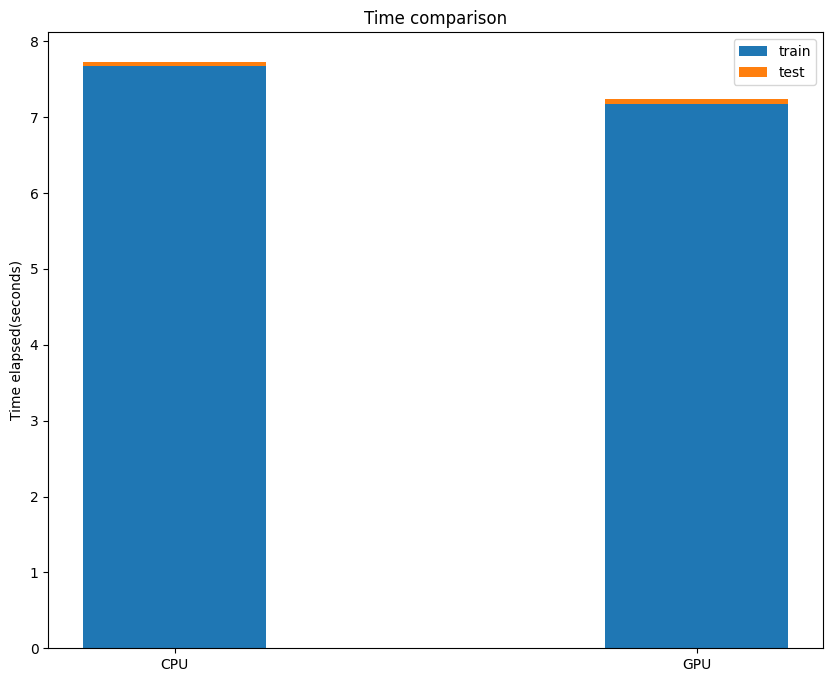

In [ ]:
import matplotlib.pyplot as plt

TRAIN = (CPU_train,GPU_train)
TEST = (CPU_test,GPU_test)
ind = np.arange(2)
width = 0.35
fig = plt.subplots(figsize =(10, 8))
p1 = plt.bar(ind, TRAIN, width)
p2 = plt.bar(ind, TEST, width,bottom = TRAIN)

plt.ylabel('Time elapsed(seconds)')
plt.title('Time comparison')
plt.xticks(ind, ('CPU', 'GPU'))
#plt.yticks(np.arange(0, CPU_time+ CPU_time/7, CPU_time/5))
plt.legend((p1[0], p2[0]), ('train', 'test'))

plt.show()




#Βήμα 7



In [ ]:
import copy



def test_loop2(dataloader, model, loss_fn):
    model_copy=copy.deepcopy(model)
    y_total=torch.empty(0, dtype=torch.float32).to(device)
    y_pred_total=torch.empty(0, dtype=torch.float32).to(device)
    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():
        for X, y in dataloader:

            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)

            pred = model(X)

            y_total=torch.cat((y_total,y))
            y_pred_total=torch.cat((y_pred_total,pred.argmax(1)))

    y_total = y_total.cpu().numpy() # numpy conversion needs cpu device
    y_pred_total = y_pred_total.cpu().numpy()

    #print(f"F1 score: {100*f1_score(y_total,y_pred_total,average='macro'):>0.1f}%\n")
    return model_copy , 100*f1_score(y_total,y_pred_total,average='macro')

In [ ]:


def train2(num_epochs , optimizer , train_dataloader, val_dataloader ,loss_fn, model):  # model= neural model
  max_f1=0
  max_model= model
  for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    cur_model, f1 =  test_loop2(val_dataloader, model, loss_fn)
    print(f"f1: {f1}\n_______________________________")
    if(f1>max_f1):
      max_model=copy.deepcopy(cur_model)
      max_f1=f1

  return max_model


In [ ]:
##### initializations ################
X = torch.rand(1,26, device = device)

model = NeuralNetwork().to(device)

logits = model(X).to(device)

learning_rate= 0.002

optimizer=torch.optim.SGD(model.parameters(), lr = learning_rate)
##############################


myModel = train2(30 , optimizer , train_dataloader,val_dataloader , nn.CrossEntropyLoss() , model)



Epoch 1
-------------------------------
f1: 10.020040080160319
_______________________________
Epoch 2
-------------------------------
f1: 12.17343974657206
_______________________________
Epoch 3
-------------------------------
f1: 14.814514189514192
_______________________________
Epoch 4
-------------------------------
f1: 26.8895163035772
_______________________________
Epoch 5
-------------------------------
f1: 30.887536707153718
_______________________________
Epoch 6
-------------------------------
f1: 27.883355176933154
_______________________________
Epoch 7
-------------------------------
f1: 26.694775132275133
_______________________________
Epoch 8
-------------------------------
f1: 28.014267409196197
_______________________________
Epoch 9
-------------------------------
f1: 44.170865935025695
_______________________________
Epoch 10
-------------------------------
f1: 25.42117117117117
_______________________________
Epoch 11
-------------------------------
f1: 47.28233

In [ ]:
loss ,f1,acc,CM= test_loop(test_dataloader, myModel, nn.CrossEntropyLoss())

print("Avg. loss",loss)
print("f1",f1)
print("accuracy",acc)
print("Confusion Matrix",CM)

Avg. loss 0.06551515984587199
f1 59.07774032482549
accuracy 60.82848837209303
Confusion Matrix [[ 74  28 124  98]
 [ 29 241  16  11]
 [ 57  19 267  13]
 [ 51  32  61 255]]


Δεν διαφέρει ιδιαίτερα το αποτέλεσμα . Όπως και να 'χει το πιο ακριβές μοντέλο με βάση το validation set δεν θα ήταν και αναγκαία το πιο ακριβές για το test set . Έτσι , όμως αποφεύγουμε την προσμαρμογή σε ιδιότητες μόνο του train ή του test set (καλύτερη γενίκευση) καθώς και περιπτώσεις που το SGD μειώνει σε κάποιες εποχές σημαντικά σε απόδοση(όπως φαίνεται στις εκτυπώσεις στις 30 εποχές υπάρχουν ακόμα αρκετές διακυμάνσεις)

In [ ]:
loss ,f1,acc,CM= test_loop(val_dataloader, myModel, nn.CrossEntropyLoss())

print("The best f1 for the validation set was",f1)

The best f1 for the validation set was 65.8930995098832


# Ερώτημα 2


#Βήμα 1

In [ ]:
#data_path=('/content/drive/MyDrive/Anagnorisi Protypon - Machine Learning/Ergasia3/data/music_genre_data_di/')

train_X = np.load(data_path + 'train/melgrams/X.npy')
test_X = np.load(data_path + 'test/melgrams/X.npy')
val_X = np.load(data_path + 'val/melgrams/X.npy')

train_labels_STR=np.load(data_path + 'train/melgrams/labels.npy')
test_labels_STR=np.load(data_path + 'test/melgrams/labels.npy')
val_labels_STR=np.load(data_path + 'val/melgrams/labels.npy')

In [ ]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)])

In [ ]:
# same with CustomDataset , only change is an added dimension

class MelDataset:
    def __init__(self, X,labels, transform=None, target_transform=None):
        self.X = X
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data=self.X[idx,:]  # data = MFCCs or Melgrams
        label = self.labels[idx]
        if self.transform !=None :
            data = self.transform(data)
            if(data.dim()==2):        #conv2d needs data dimensions in this sequence: [batches ,channels ,height,width]
              data = data[None, :]   # For now an extra dimension is needed for the channels (we need n_channels=1)
        if self.target_transform:
            label = self.target_transform(label)

        return data , label

In [ ]:
train_labels= list( map(toInt,train_labels_STR))
val_labels= list( map(toInt,val_labels_STR))
test_labels= list( map(toInt,test_labels_STR))

train_data=MelDataset(train_X,train_labels,transform=transform)
val_data=MelDataset(val_X,val_labels,transform=transform)
test_data=MelDataset(test_X,test_labels,transform=transform)

train_dataloader_mel = DataLoader(train_data, batch_size=16, shuffle=True)
val_dataloader_mel = DataLoader(val_data, batch_size=16, shuffle=True)
test_dataloader_mel = DataLoader(test_data, batch_size=16)

In [ ]:
from collections import Counter

Counter(train_labels_STR)

Counter({'blues': 800,
         'classical': 800,
         'hiphop': 800,
         'rock_metal_hardrock': 800})

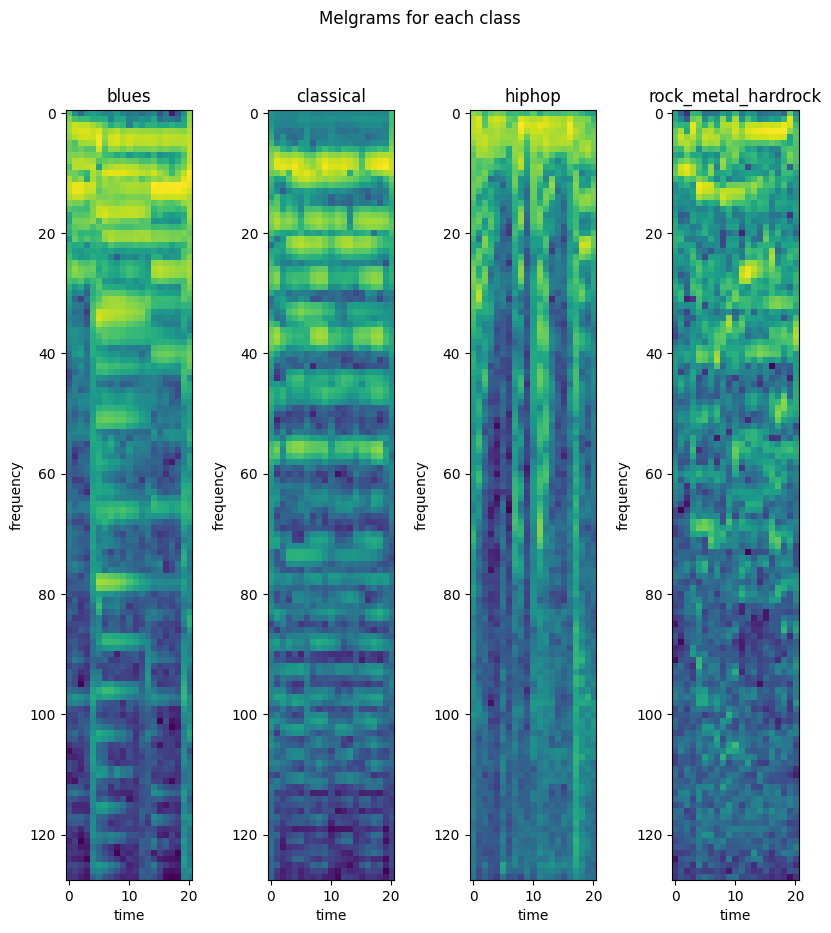

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

import random

fig, axs = plt.subplots(1,4,figsize=(10, 10))

fig.suptitle('Melgrams for each class')


for i in range (0,4):
  axs[i].set_xlabel('time')
  axs[i].set_ylabel('frequency')
  axs[i].set_title(list(mapping.keys())[i])
  axs[i].imshow(train_X[random.randrange(i*800, (i+1)*800)].T)





#Βήμα 2

In [ ]:
class SimpleNet(nn.Module):
  def __init__(self):
    super().__init__()
    # in channels, out_channels, kernel_size
    self.conv1 = nn.Conv2d(1, 16, 5)
    self.conv2 = nn.Conv2d(16, 32, 5)
    self.conv3 = nn.Conv2d(32, 64, 5)
    self.conv4 = nn.Conv2d(64, 128, 5)

    self.dense1 = nn.Linear(71680 , 1024)   # estimated using the algorithm with forms: W2= (W1 - f +2p )/S +1 , H2= (H1 - f +2p )/S +1 , no padding(p=0)
    self.dense2 = nn.Linear( 1024 , 256 )
    self.dense3 = nn.Linear( 256 , 32)
    self.dense4 = nn.Linear( 32 , 4 )
    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
      x = F.relu(self.conv1(x))  ## import torch.nn.functional as F
      x = F.relu(self.conv2(x))
      x = F.relu(self.conv3(x))
      x = F.relu(self.conv4(x))


      x = x.view(-1, 71680) ##reshapes the tensor without copying memory, similar to numpy's  //convert to ?X800

      x = self.dropout(x)
      x = F.relu(self.dense1(x))
      x = self.dropout(x)
      x = F.relu(self.dense2(x))
      x = self.dropout(x)
      x = F.relu(self.dense3(x))
      x = self.dropout(x)
      x=self.dense4(x)

      return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
simple_net = SimpleNet().to(device)
print (simple_net)


SimpleNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (dense1): Linear(in_features=71680, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [ ]:
from torchvision import models
from torchsummary import summary
summary(simple_net,(1, 21, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 17, 124]             416
            Conv2d-2          [-1, 32, 13, 120]          12,832
            Conv2d-3           [-1, 64, 9, 116]          51,264
            Conv2d-4          [-1, 128, 5, 112]         204,928
           Dropout-5                [-1, 71680]               0
            Linear-6                 [-1, 1024]      73,401,344
           Dropout-7                 [-1, 1024]               0
            Linear-8                  [-1, 256]         262,400
           Dropout-9                  [-1, 256]               0
           Linear-10                   [-1, 32]           8,224
          Dropout-11                   [-1, 32]               0
           Linear-12                    [-1, 4]             132
Total params: 73,941,540
Trainable params: 73,941,540
Non-trainable params: 0
-------------------------

#Βήμα 3

In [ ]:
def train_loop_mel(dataloader, model, loss_fn, optimizer):


############   THIS WAS ADDED IN SEMINAR 9 ####################
  # we need to switch to training model. This is necessary when our model employs dropout, batch normalization and other such
  # layers that behave differently between training and evaluation
  model.train()
################################################################

  size = len(dataloader.dataset)
  loss_total = 0.
  for batch, (X, y) in enumerate(dataloader):

        # if using gpu dont forget to move the data there
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ##############  from here on function just prints extra info about the loss
        loss_it = loss.item()
        loss_total += loss_it

        # per 100 batches report the value of the loss function on the training set
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [ ]:
import copy

def eval_loop_mel(dataloader, model, loss_fn):

######## ADDED: ######################
    # need to switch to evaluation mode due to the presence of the dropout layer.
    model.eval()
#####################################

    model_copy=copy.deepcopy(model) # for safety reasons that the model returned won't be modified
    y_total=torch.empty(0, dtype=torch.float32).to(device)
    y_pred_total=torch.empty(0, dtype=torch.float32).to(device)
    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():
        for X, y in dataloader:

            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)

            pred = model(X)

            y_total=torch.cat((y_total,y))
            y_pred_total=torch.cat((y_pred_total,pred.argmax(1)))

    y_total = y_total.cpu().numpy() # numpy conversion needs cpu device
    y_pred_total = y_pred_total.cpu().numpy()

    return model_copy , 100*f1_score(y_total,y_pred_total,average='macro')  # returns copy of the model itself and its f1 score

In [ ]:
def train_mel(num_epochs , optimizer , train_dataloader, val_dataloader ,loss_fn, model):  # ADDED THE NEW LOOP FUNCTIONS TO COMPLETE TRAIN FUNCTION
  max_f1=0
  max_model= model
  for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop_mel(train_dataloader, model, loss_fn, optimizer)  # MODIFICATION
    cur_model, f1 =  eval_loop_mel(val_dataloader, model, loss_fn) # MODIFICATION
    print(f"f1:{f1}\n_________________________________")
    if(f1>max_f1):
      max_model=copy.deepcopy(cur_model)
      max_f1=f1


  return max_model


In [ ]:
# run the cell with Simple_Net class before running this

import torch


start=time.time()
optimizer=optim.SGD(simple_net.parameters(),0.02)
mySimpleModel = train_mel(30 , optimizer , train_dataloader_mel,val_dataloader_mel , nn.CrossEntropyLoss() , simple_net) # see 'net' initialization in 'ΒΗΜΑ 2'

print(f"Training took {time.time() - start} seconds ")


Epoch 1
-------------------------------
loss: 1.420298  [    0/ 3200]
loss: 1.333335  [ 1600/ 3200]
f1:10.0
_________________________________
Epoch 2
-------------------------------
loss: 1.382361  [    0/ 3200]
loss: 1.398276  [ 1600/ 3200]
f1:47.78975386472373
_________________________________
Epoch 3
-------------------------------
loss: 1.070685  [    0/ 3200]
loss: 1.290221  [ 1600/ 3200]
f1:36.76449702925492
_________________________________
Epoch 4
-------------------------------
loss: 1.047902  [    0/ 3200]
loss: 1.083296  [ 1600/ 3200]
f1:58.763589102095615
_________________________________
Epoch 5
-------------------------------
loss: 1.091792  [    0/ 3200]
loss: 0.718866  [ 1600/ 3200]
f1:42.422822460408064
_________________________________
Epoch 6
-------------------------------
loss: 1.458991  [    0/ 3200]
loss: 0.873805  [ 1600/ 3200]
f1:60.49175295769391
_________________________________
Epoch 7
-------------------------------
loss: 0.217367  [    0/ 3200]
loss: 0.626

In [ ]:
current_device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Training took place on ",current_device)

Training took place on  cuda


In [ ]:
def test_mel(dataloader, model, loss_fn):

######## ADDED: ######################
    # need to switch to evaluation mode due to the presence of the dropout layer.
    model.eval()
#####################################

    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    y_total=torch.empty(0, dtype=torch.float32).to(device)
    y_pred_total=torch.empty(0, dtype=torch.float32).to(device)
    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():
        for X, y in dataloader:

            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            y_total=torch.cat((y_total,y))
            y_pred_total=torch.cat((y_pred_total,pred.argmax(1)))

    accuracy= 100*(y_pred_total == y_total).type(torch.float).sum().item()/size

    y_total = y_total.cpu().numpy() # numpy conversion needs cpu device
    y_pred_total = y_pred_total.cpu().numpy()

    test_loss /= size
    f1= 100*f1_score(y_total,y_pred_total,average='macro')
    CM=confusion_matrix(y_total,y_pred_total,labels=[0,1,2,3])

    return test_loss,f1,accuracy,CM

In [ ]:
loss ,f1,acc,CM = test_mel(test_dataloader_mel, mySimpleModel, nn.CrossEntropyLoss())

print("Avg. loss",loss)
print("f1",f1)
print("accuracy",acc)
print("Confusion Matrix",CM)

Avg. loss 0.08720435795027676
f1 59.6612449136919
accuracy 58.72093023255814
Confusion Matrix [[133  18  70 103]
 [ 61 205   3  28]
 [ 62   6 235  53]
 [111  16  37 235]]


#Τι παρατηρείτε; Μπορεί να εκπαιδευτεί το δίκτυο;

Τα feature maps έχουν πολύ μεγάλες διαστάσεις (φτάνουν έως και 5X112X128 = 71680) που κάνει πολύπλοκες τις πράξεις και οι επιδόσεις κυμαίνοταν γύρω στο 60% ενώ και ο χρόνος εκπαίδευσης δεν είναι ικανοποιητικός δεδομένου ότι πραγαματοποιήθηκαν μόνο 30 εποχές εκπαίδευσης(στα επόμενα βήματα θα φανεί ότι δεν αρκούν για επιδόσεις >80%). Η προσθήκη pooling εφόσον πραγματοποιεί μείωση διαστάσεων αναμένεται να δώσει λύσεις στο πρόβλημα.

#Βήμα 4

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    # in channels, out_channels, kernel_size , stride , padding
    self.conv1 = nn.Conv2d(1, 16, 5, 1, 2)
    self.conv2 = nn.Conv2d(16, 32, 5, 1 , 2)
    self.conv3 = nn.Conv2d(32, 64, 5, 1 , 2)
    self.conv4 = nn.Conv2d(64, 128, 5, 1 , 2)

    self.max_pool = nn.MaxPool2d(2,2) # kernel_size=2 , stride = 2

    self.dense1 = nn.Linear(1024 , 1024)   # estimated using the forms: W2= (W1 - f +2p )/S +1 , H2= (H1 - f +2p )/S +1
    self.dense2 = nn.Linear( 1024 , 256 )
    self.dense3 = nn.Linear( 256 , 32)
    self.dense4 = nn.Linear( 32 , 4 )

    self.dropout = nn.Dropout(0.25)

  def forward(self, x):

      x = self.max_pool(F.relu(self.conv1(x)))  ## import torch.nn.functional as F
      x = self.max_pool(F.relu(self.conv2(x)))
      x = self.max_pool(F.relu(self.conv3(x)))
      x = self.max_pool(F.relu(self.conv4(x)))

      x = x.view(-1, 1024)
      x = self.dropout(x)
      x = F.relu(self.dense1(x))
      x = self.dropout(x)
      x = F.relu(self.dense2(x))
      x = self.dropout(x)
      x = F.relu(self.dense3(x))
      x = self.dropout(x)
      x = self.dense4(x)

      return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
cnn = CNN().to(device)
print (cnn)


CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1024, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=32, bias=True)
  (dense4): Linear(in_features=32, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [ ]:
#from torchvision import models
#from torchsummary import summary
#summary(cnn,(1, 21, 128)) ##show summary for

In [ ]:
from torch import optim
import time

cnn = CNN().to(device)

optimizer = optim.SGD(cnn.parameters(), lr=0.02)

start=time.time()

# TRAIN
myModel = train_mel(30 , optimizer , train_dataloader_mel , val_dataloader_mel , nn.CrossEntropyLoss() , cnn)

print(f"Training took {time.time() - start} seconds ")

Epoch 1
-------------------------------
loss: 1.389178  [    0/ 3200]
loss: 1.405440  [ 1600/ 3200]
f1:10.276395689531649
_________________________________
Epoch 2
-------------------------------
loss: 1.359884  [    0/ 3200]
loss: 1.396048  [ 1600/ 3200]
f1:15.0472334682861
_________________________________
Epoch 3
-------------------------------
loss: 1.374784  [    0/ 3200]
loss: 1.212936  [ 1600/ 3200]
f1:52.91404128085531
_________________________________
Epoch 4
-------------------------------
loss: 1.217735  [    0/ 3200]
loss: 1.141250  [ 1600/ 3200]
f1:48.75700775193195
_________________________________
Epoch 5
-------------------------------
loss: 1.252902  [    0/ 3200]
loss: 1.036031  [ 1600/ 3200]
f1:42.61323460118616
_________________________________
Epoch 6
-------------------------------
loss: 1.114065  [    0/ 3200]
loss: 0.871885  [ 1600/ 3200]
f1:59.660169965075006
_________________________________
Epoch 7
-------------------------------
loss: 1.004477  [    0/ 3200]

# Τι επίδοση πετυχαίνετε;

In [ ]:
loss ,f1,acc,CM = test_mel(test_dataloader_mel, myModel, nn.CrossEntropyLoss())

print("Avg. loss",loss)
print("f1",f1)
print("accuracy",acc)
print("Confusion Matrix",CM)

Avg. loss 0.04433958242081517
f1 71.73130719520758
accuracy 71.36627906976744
Confusion Matrix [[161  21  19 123]
 [ 18 270   0   9]
 [ 39   7 250  60]
 [ 65  11  22 301]]


#Σχόλια

Το pooling μειώνει τις διαστάσεις κάθε πίνακα συνέλιξης (ή τουλάχιστον των διαστάσεων με χαρακτηριστικά γιατί υπάρχουν και οι γραμμές και στήλες με 0 για το padding) και κάνει πιο γρήγορες τις πράξεις . Επιπλέον, είναι χρήσιμα ώστε να εντοπίζονται χαρακτηριστικά σε μια εικόνα ανεξάρτητα από το σημείο στο οποίο βρίσκεται το χαρακτηριστικό (με max pooling παίρνουμε τη μέγιστη τιμή από κάθε επιμέρους 2X2 κομμάτι του πίνακα συνέλιξης χωρίς να παίζει ρόλο σε ποια από τις 4 πιθανές θέσεις βρισκόταν αυτή η τιμή ).

Το padding ήταν αναγκαίο γιατί σε ύπαρξη περιττής/ων διάστασης/εων δεν θα χώραγαν όλα τα δεδομένα στο pooling (που κρατούσε τη μέγιστη τιμή από κάθε υποπίνακα 2x2) . Οπότε , αξιοποιήθηκαν οι επιπλέον γραμμές και στήλες του padding.


#Βήμα 5

Οι ακόλουθες αλλαγές στις συναρτήσεις για training και testing αφορούν μόνο την αφαίρεση εκτυπώσεων και παραπανήσιων υπολογισμών  

In [ ]:
def test_f1_acc(dataloader, model, loss_fn): #!!! we compare optimizers based only on f1 and accuracy
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    y_total=torch.empty(0, dtype=torch.float32).to(device)
    y_pred_total=torch.empty(0, dtype=torch.float32).to(device)
    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():
        for X, y in dataloader:

            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)



            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            y_total=torch.cat((y_total,y))
            y_pred_total=torch.cat((y_pred_total,pred.argmax(1)))

    accuracy= 100*(y_pred_total == y_total).type(torch.float).sum().item()/size

    y_total = y_total.cpu().numpy() # numpy conversion needs cpu device
    y_pred_total = y_pred_total.cpu().numpy()

#    test_loss /= size
    f1= 100*f1_score(y_total,y_pred_total,average='macro')
#    CM=confusion_matrix(y_total,y_pred_total,labels=[0,1,2,3])

    return f1,accuracy


def train_loop_mel_no_printing(dataloader, model, loss_fn, optimizer):


############   THIS WAS ADDED IN SEMINAR 9 ####################
  # we need to switch to training model. This is necessary when our model employs dropout, batch normalization and other such
  # layers that behave differently between training and evaluation
  model.train()
################################################################

  size = len(dataloader.dataset)
  loss_total = 0.
  for batch, (X, y) in enumerate(dataloader):

        # if using gpu dont forget to move the data there
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def train_mel_no_printing(num_epochs , optimizer , train_dataloader, val_dataloader ,loss_fn, model):  # ADDED THE NEW LOOP FUNCTIONS TO COMPLETE TRAIN FUNCTION
  max_f1=0
  max_model= model
  for t in range(num_epochs):
    #print(f"Epoch {t+1}\n-------------------------------")
    train_loop_mel_no_printing(train_dataloader, model, loss_fn, optimizer)  # MODIFICATION
    cur_model, f1 =  eval_loop_mel(val_dataloader, model, loss_fn) # MODIFICATION
    #print(f"f1:{f1}\n_________________________________")
    if(f1>max_f1):
      max_model=copy.deepcopy(cur_model)
      max_f1=f1


  return max_model

In [ ]:
# We 'll need a list of f1 and accuracy scores

f1s=[]
accs=[]

f1s.append(f1)  # for SGD f1 and accuracy were alreade found on last cell of 'Βήμα 4'
accs.append(acc)

In [ ]:
# We create a function that trains a CNN model with a specific optimizer and saves the testing scores in 'f1s' and 'accs'

lr = 0.02 # !the same learning rate is used


def opt_evaluate(f1s,accs,myoptimizer):

  mynet = CNN().to(device)
  optimizer=  myoptimizer(mynet.parameters(),lr)

  myModel = train_mel_no_printing(30 , optimizer , train_dataloader_mel,val_dataloader_mel , nn.CrossEntropyLoss() , mynet)
  f1,acc= test_f1_acc(test_dataloader_mel, myModel , nn.CrossEntropyLoss())
  f1s.append(f1)
  accs.append(acc)


#We run the function for different optimizers
for opt in [optim.Adadelta,optim.Adagrad,optim.Adam,optim.AdamW,optim.Adamax,optim.ASGD,optim.NAdam,optim.RAdam,optim.RMSprop,optim.Rprop]:
  print("evaluating ",opt)
  opt_evaluate(f1s,accs,opt)

evaluating  <class 'torch.optim.adadelta.Adadelta'>
evaluating  <class 'torch.optim.adagrad.Adagrad'>
evaluating  <class 'torch.optim.adam.Adam'>
evaluating  <class 'torch.optim.adamw.AdamW'>
evaluating  <class 'torch.optim.adamax.Adamax'>
evaluating  <class 'torch.optim.asgd.ASGD'>
evaluating  <class 'torch.optim.nadam.NAdam'>
evaluating  <class 'torch.optim.radam.RAdam'>
evaluating  <class 'torch.optim.rmsprop.RMSprop'>
evaluating  <class 'torch.optim.rprop.Rprop'>


In [ ]:
# we create an appropriate dataframe to present the results

import pandas as pd

# remember the first scores that were added
columns=["SGD","Adadelta","Adagrad","Adam","AdamW","Adamax","ASGD","NAdam","RAdam","RMSprop","Rprop"]

df = pd.DataFrame([f1s, accs], index=['f1','accuracy'], columns=columns)
df

,SGD,Adadelta,Adagrad,Adam,AdamW,Adamax,ASGD,NAdam,RAdam,RMSprop,Rprop
f1,71.731307,75.855823,70.665593,11.239437,11.239437,9.529412,70.494556,21.86070,11.239437,10.277136,42.915826
accuracy,71.366279,74.927326,70.566860,28.997093,28.997093,23.546512,70.494186,35.02907,28.997093,25.872093,47.529070


#Σημαντική Σημείωση:

Τρέχοντας την opt_evalueate παραπάνω από μια φορά κάποιοι αλγόριθομοι μπορεί να παρουσίαζαν μεγάλες διαφορές στα αποτελέσματα ή/και υπερβολικά χαμηλές επιδόσεις . Κάθε φορά εκπαιδεύεται από την αρχή ένα CNN δίκτυο οπότε ίσως να μην είναι τόσο περίεργο αυτό , για παράδειγμα λόγω τοπικών ελαχίστων . Ο σχολιασμός έγινε στην πρώτη φορά που έτρεξαν οι αξιολογήσεις και έτυχε οι επιδόσεις να κυμαίνονται περίπου στο εύρος 40-75%

#Σχολιασμός Διαφορών(από ένα τρέξιμο)

-SGD vs Adam και εκδοχές (45-60% vs 67-75%):

Μέσα από μικρή έρευνα παρατηρείται πώς ο αλγόριθμος Adam φημίζεται για το ότι συγκλίνει πιο γρήγορα από τον SGD ενώ ο SGD φτάνει σε πιο βέλτιστες λύσεις . Αν δεχθούμε αυτή την παραδοχή , βγάζει νόημα το γέγονος ότι οι αλγόριθμο που είναι εκδοχές του SGD(SGD,ASGD) γενικά πάνε χειρότερα από αυτούς που είναι εκδοχές του Adam (Adam , AdamW, Adamax ,Nadam , RAdam) αφού βρίσκομαστε σε ένα στάδιο που τα βάρη βρίσκονται ακόμα μάκρια από τις καλύτερες λύσεις . Ίσως σε μεγάλο αριθμό επόχων ,όπου θα είναι υψηλές οι ακρίβειες, να μην είναι πρόφανες ποιός είναι ο κατάλληλος optimizer αλλά για τώρα οι εκδοχές του Adam "φτάνουν γρηγορότερα" σε βάρη με μια ικανοποιητική(σε επίπεδα σύγκρισης) ακρίβεια .

Update: Σε άλλο τρέξιμο ο SGD κι ο ASGD έφτασαν το 70% σε επιδόσεις και οι εκδοσεις του Adam κάτω απο 30%accuracy και κάτω από 20% f1


-ASGD vs SGD(45% vs 60%): Δεν αναφαίρεται κάπου ότι συγκλίνει πιο αργά ο ASGD(Average Stohastic gradient Descent) . Ίσως αφού η νέα τιμή κάθε φορά είναι το μέσο όλων των βαρών σε κάθε επανάληψη o αλγόριθμος να πηγαίνει με πιο σταθερό ρυθμό στα βέλτιστα βάρη και να μην αλλάζει τόσο εύκολα κατεύθυνση . Δεν θα ήταν περίεργο με περισσότερες εποχές ο ASGD να φτάσει ή και να περάσει τον SGD , προφανώς αυτό είναι κάτι που εξαρτάται κάθε φορά από το πρόβλημα .

Update: Σε άλλο τρέξιμο ο SGD κι ο ASGD έφτασαν το 70% σε επιδόσεις


-Adagrad(περίπου 70%):

Φαίνεται να προσαρμόζει τα learning rate στους παραμέτρους διατηρόντας χαμηλά lrs σε χαρακτηριστικά με μεγάλη συχνότητα και υψηλά σε χαρ/κα με μικρή (https://www.ruder.io/optimizing-gradient-descent/#adagrad). Συστίνεται για sparse data ("the data stored for a particular feature contains mostly zeroes"),άρα άφου δεν έχει κακή απόδοση ίσως τα melgrams να είναι "αραιά" σε κάποια σημεία.

